# Importation des biblio

In [107]:
import pandas as pd
import math
import pandas as pd
import numpy as np
import sklearn.metrics as sm
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import datasets
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import warnings
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.impute import KNNImputer

warnings.filterwarnings(action='ignore')

data = []
with open('chronic_kidney_disease.arff', "r") as f:
    for line in f:
        line = line.replace('\n', '')
        data.append(line.split(','))


names = ['age', 'bp', 'sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba',
         'bgr', 'bu',  'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc',
         'rbcc', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane',
         'class']
    
df = pd.DataFrame(data, columns=names)

# remplacer les ? par Nan

In [108]:
df=df.replace('?', math.nan)
df.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,48,80,1.020,1,0,NaN,normal,notpresent,notpresent,121,...,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,7,50,1.020,4,0,NaN,normal,notpresent,notpresent,NaN,...,38,6000,NaN,no,no,no,good,no,no,ckd
2,62,80,1.010,2,3,normal,normal,notpresent,notpresent,423,...,31,7500,NaN,no,yes,no,poor,no,yes,ckd
3,48,70,1.005,4,0,normal,abnormal,present,notpresent,117,...,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,51,80,1.010,2,0,normal,normal,notpresent,notpresent,106,...,35,7300,4.6,no,no,no,good,no,no,ckd


# préparation des données

In [109]:
cols=['age','bp','sg','al','su','bgr','bu','sc','sod','pot','hemo','pcv','wbcc','rbcc']
for i in cols:
    df[i] = pd.to_numeric(df[i], errors='coerce')


In [110]:
# Extracting categorical and numerical columns
categorical_df=[]
numerical_df=[]
for col in df.columns:
    if df[col].dtype=='object':
        categorical_df.append(col)
    if df[col].dtype=='float64':
        numerical_df.append(col)

In [111]:
for col in categorical_df:
    print(f"{col} has {df[col].unique()} values\n")

rbc has [nan 'normal' 'abnormal'] values

pc has ['normal' 'abnormal' nan] values

pcc has ['notpresent' 'present' nan] values

ba has ['notpresent' 'present' nan] values

htn has ['yes' 'no' nan] values

dm has ['yes' 'no' ' yes' '\tno' nan] values

cad has ['no' 'yes' nan] values

appet has ['good' 'poor' nan] values

pe has ['no' 'yes' nan] values

ane has ['no' 'yes' nan] values

class has ['ckd' 'ckd\t' 'notckd'] values



# replace incorrect values

In [112]:

df['dm'].replace(to_replace = {'\tno':'no','\tyes':'yes',' yes':'yes'},inplace=True)

df['cad'] = df['cad'].replace(to_replace = '\tno', value='no')

df['class'] = df['class'].replace(to_replace = {'ckd\t': 'ckd', 'notckd': 'not ckd'})

# checking null values 

In [113]:
df.isna().sum().sort_values(ascending = False)


rbc      152
rbcc     131
wbcc     106
pot       88
sod       87
pcv       71
pc        65
hemo      52
su        49
sg        47
al        46
bgr       44
bu        19
sc        17
bp        12
age        9
ba         4
pcc        4
htn        2
dm         2
cad        2
appet      1
pe         1
ane        1
class      0
dtype: int64

#  prendre les colonnes numeriques et categorique

In [114]:
categ_df=df[categorical_df]
normam_df=df[numerical_df]

# traitement des colonnes catégoriques 

In [115]:
imputer = SimpleImputer(strategy='most_frequent')
dd=imputer.fit_transform(categ_df)
categ_df = pd.DataFrame(dd, columns = categorical_df)
categ_df.tail()

,rbc,pc,pcc,ba,htn,dm,cad,appet,pe,ane,class
395,normal,normal,notpresent,notpresent,no,no,no,good,no,no,not ckd
396,normal,normal,notpresent,notpresent,no,no,no,good,no,no,not ckd
397,normal,normal,notpresent,notpresent,no,no,no,good,no,no,not ckd
398,normal,normal,notpresent,notpresent,no,no,no,good,no,no,not ckd
399,normal,normal,notpresent,notpresent,no,no,no,good,no,no,not ckd


In [116]:
frames = [categ_df,normam_df]
df = pd.concat([normam_df, categ_df], axis=1)

In [117]:
df.head()

,age,bp,sg,al,su,bgr,bu,sc,sod,pot,...,pc,pcc,ba,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1.0,0.0,121.0,36.0,1.2,NaN,NaN,...,normal,notpresent,notpresent,yes,yes,no,good,no,no,ckd
1,7.0,50.0,1.020,4.0,0.0,NaN,18.0,0.8,NaN,NaN,...,normal,notpresent,notpresent,no,no,no,good,no,no,ckd
2,62.0,80.0,1.010,2.0,3.0,423.0,53.0,1.8,NaN,NaN,...,normal,notpresent,notpresent,no,yes,no,poor,no,yes,ckd
3,48.0,70.0,1.005,4.0,0.0,117.0,56.0,3.8,111.0,2.5,...,abnormal,present,notpresent,yes,no,no,poor,yes,yes,ckd
4,51.0,80.0,1.010,2.0,0.0,106.0,26.0,1.4,NaN,NaN,...,normal,notpresent,notpresent,no,no,no,good,no,no,ckd


In [118]:
label_encoder = preprocessing.LabelEncoder()
for i  in categorical_df:
    df[i]= label_encoder.fit_transform(df[i])

In [119]:
df.head()

,age,bp,sg,al,su,bgr,bu,sc,sod,pot,...,pc,pcc,ba,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1.0,0.0,121.0,36.0,1.2,NaN,NaN,...,1,0,0,1,1,0,0,0,0,0
1,7.0,50.0,1.020,4.0,0.0,NaN,18.0,0.8,NaN,NaN,...,1,0,0,0,0,0,0,0,0,0
2,62.0,80.0,1.010,2.0,3.0,423.0,53.0,1.8,NaN,NaN,...,1,0,0,0,1,0,1,0,1,0
3,48.0,70.0,1.005,4.0,0.0,117.0,56.0,3.8,111.0,2.5,...,0,1,0,1,0,0,1,1,1,0
4,51.0,80.0,1.010,2.0,0.0,106.0,26.0,1.4,NaN,NaN,...,1,0,0,0,0,0,0,0,0,0


# Visualisation des outliers 

<Figure size 432x288 with 0 Axes>

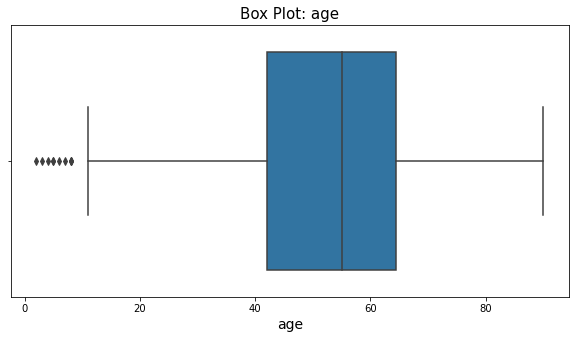

<Figure size 432x288 with 0 Axes>

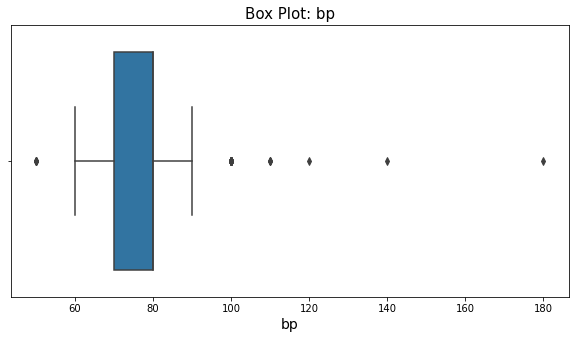

<Figure size 432x288 with 0 Axes>

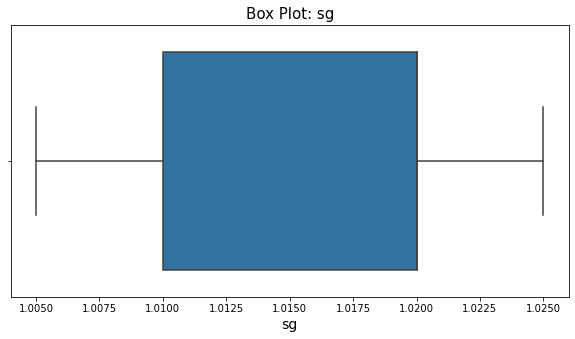

<Figure size 432x288 with 0 Axes>

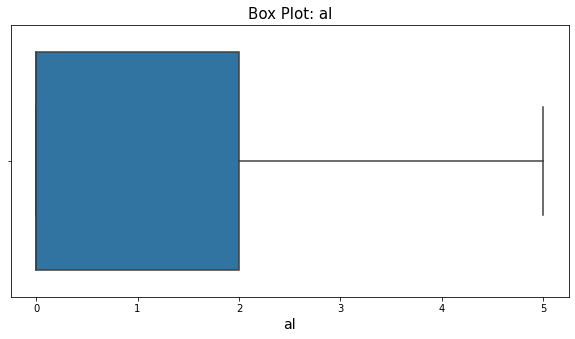

<Figure size 432x288 with 0 Axes>

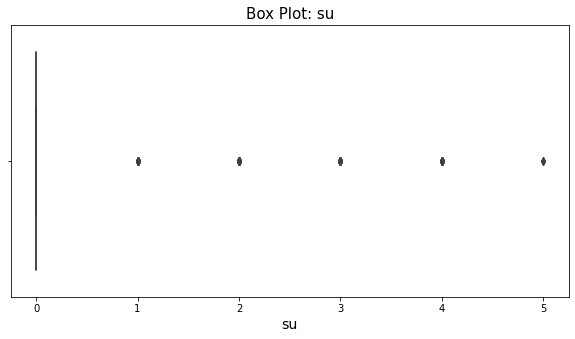

<Figure size 432x288 with 0 Axes>

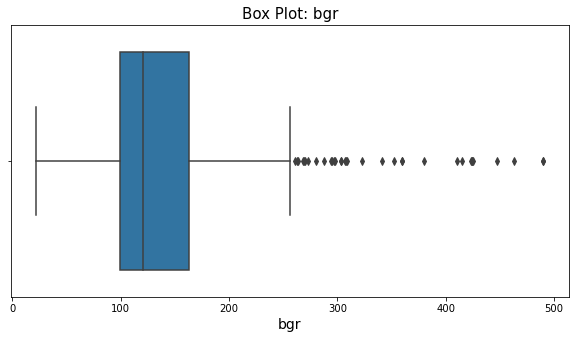

<Figure size 432x288 with 0 Axes>

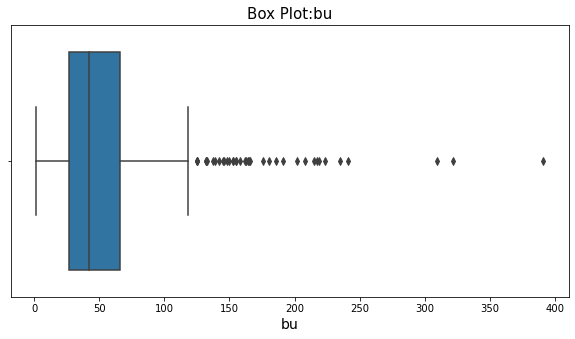

<Figure size 432x288 with 0 Axes>

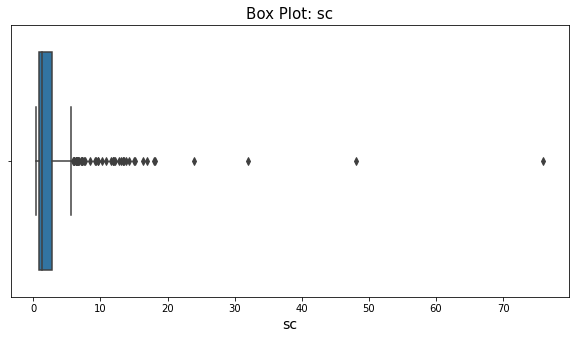

<Figure size 432x288 with 0 Axes>

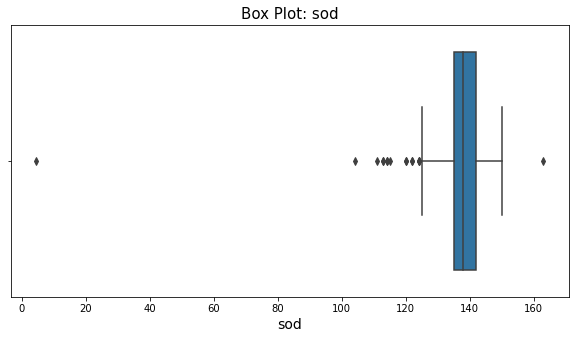

<Figure size 432x288 with 0 Axes>

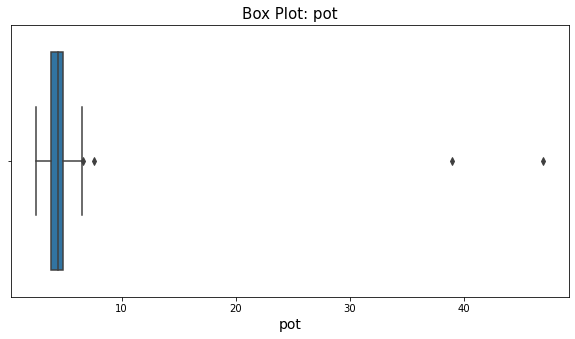

<Figure size 432x288 with 0 Axes>

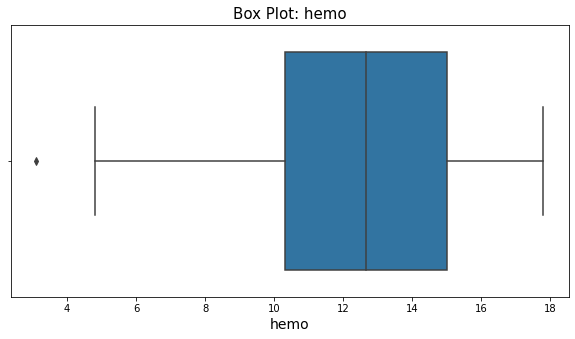

<Figure size 432x288 with 0 Axes>

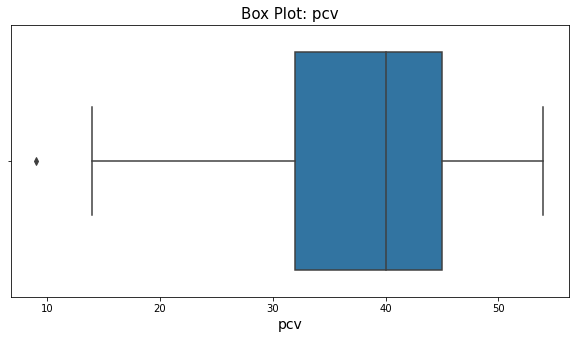

<Figure size 432x288 with 0 Axes>

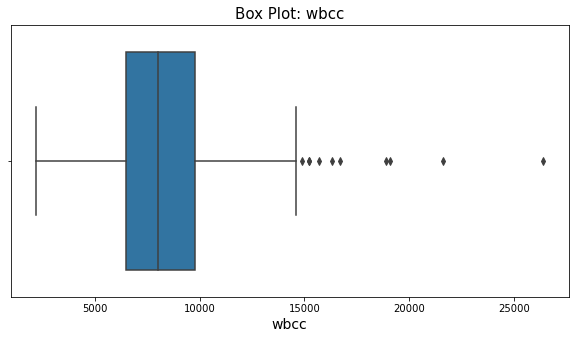

<Figure size 432x288 with 0 Axes>

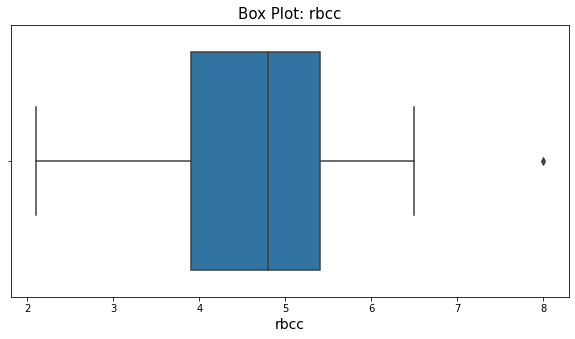

In [120]:
new_data=df
plt.figure(7)
fig = plt.figure(figsize=(10,5))
sns.boxplot(x=new_data['age'])
plt.title('Box Plot: age', fontsize=15)
plt.xlabel('age', fontsize=14)
plt.show()

plt.figure(7)
fig = plt.figure(figsize=(10,5))
sns.boxplot(x=new_data['bp'])
plt.title('Box Plot: bp', fontsize=15)
plt.xlabel('bp', fontsize=14)
plt.show()

plt.figure(7)
fig = plt.figure(figsize=(10,5))
sns.boxplot(x=new_data['sg'])
plt.title('Box Plot: sg', fontsize=15)
plt.xlabel('sg', fontsize=14)
plt.show()

plt.figure(7)
fig = plt.figure(figsize=(10,5))
sns.boxplot(x=new_data['al'])
plt.title('Box Plot: al', fontsize=15)
plt.xlabel('al', fontsize=14)
plt.show()

plt.figure(7)
fig = plt.figure(figsize=(10,5))
sns.boxplot(x=new_data['su'])
plt.title('Box Plot: su', fontsize=15)
plt.xlabel('su', fontsize=14)
plt.show()

plt.figure(7)
fig = plt.figure(figsize=(10,5))
sns.boxplot(x=new_data['bgr'])
plt.title('Box Plot: bgr', fontsize=15)
plt.xlabel('bgr', fontsize=14)
plt.show()

plt.figure(7)
fig = plt.figure(figsize=(10,5))
sns.boxplot(x=new_data['bu'])
plt.title('Box Plot:bu', fontsize=15)
plt.xlabel('bu', fontsize=14)
plt.show()

plt.figure(7)
fig = plt.figure(figsize=(10,5))
sns.boxplot(x=new_data['sc'])
plt.title('Box Plot: sc', fontsize=15)
plt.xlabel('sc', fontsize=14)
plt.show()

plt.figure(7)
fig = plt.figure(figsize=(10,5))
sns.boxplot(x=new_data['sod'])
plt.title('Box Plot: sod', fontsize=15)
plt.xlabel('sod', fontsize=14)
plt.show()

plt.figure(7)
fig = plt.figure(figsize=(10,5))
sns.boxplot(x=new_data['pot'])
plt.title('Box Plot: pot', fontsize=15)
plt.xlabel('pot', fontsize=14)
plt.show()

plt.figure(7)
fig = plt.figure(figsize=(10,5))
sns.boxplot(x=new_data['hemo'])
plt.title('Box Plot: hemo', fontsize=15)
plt.xlabel('hemo', fontsize=14)
plt.show()

plt.figure(7)
fig = plt.figure(figsize=(10,5))
sns.boxplot(x=new_data['pcv'])
plt.title('Box Plot: pcv', fontsize=15)
plt.xlabel('pcv', fontsize=14)
plt.show()

plt.figure(7)
fig = plt.figure(figsize=(10,5))
sns.boxplot(x=new_data['wbcc'])
plt.title('Box Plot: wbcc', fontsize=15)
plt.xlabel('wbcc', fontsize=14)
plt.show()

plt.figure(7)
fig = plt.figure(figsize=(10,5))
sns.boxplot(x=new_data['rbcc'])
plt.title('Box Plot: rbcc', fontsize=15)
plt.xlabel('rbcc', fontsize=14)
plt.show()







In [121]:
features = ['age', 'sg', 'bgr', 'sc', 'sod',
       'pcv', 'wbcc', 'rbcc']
print(features)

def imput_ouliers(df,feature):
    q1 = np.percentile(df[feature],25)
    q3 = np.percentile(df[feature],75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5*iqr
    upper_bound = q3 + 1.5*iqr
    df.loc[df[feature] < lower_bound ,feature ] = lower_bound
    df.loc[df[feature] > upper_bound ,feature ] = upper_bound

['age', 'sg', 'bgr', 'sc', 'sod', 'pcv', 'wbcc', 'rbcc']


In [122]:
for feature in features:
    imput_ouliers(df,feature)
    


# Imputation avec KNN et verification des paramétres 

In [123]:
rmse = lambda y, yhat: np.sqrt(mean_squared_error(y, yhat))

In [124]:
def optimize_k(data, target):
    errors = []
    for k in range(2, 20):
        imputer = KNNImputer(n_neighbors=k)
        imputed = imputer.fit_transform(data)
        df_imputed = pd.DataFrame(imputed, columns=df.columns)
        
        X = df_imputed.drop(target, axis=1)
        y = df_imputed[target]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        model = RandomForestRegressor()
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        error = rmse(y_test, preds)
        errors.append({'K': k, 'RMSE': error})
        
    return errors

In [125]:
k_errors = optimize_k(data=df, target='class')
print(k_errors)

[{'K': 2, 'RMSE': 0.10388294694831615}, {'K': 3, 'RMSE': 0.10409130607308183}, {'K': 4, 'RMSE': 0.1097914690067797}, {'K': 5, 'RMSE': 0.11395905697515518}, {'K': 6, 'RMSE': 0.12989418770676386}, {'K': 7, 'RMSE': 0.12418400326397384}, {'K': 8, 'RMSE': 0.13073510112692255}, {'K': 9, 'RMSE': 0.1277073477395356}, {'K': 10, 'RMSE': 0.13505245894342932}, {'K': 11, 'RMSE': 0.1281047748264417}, {'K': 12, 'RMSE': 0.12387157327920989}, {'K': 13, 'RMSE': 0.12559193180030845}, {'K': 14, 'RMSE': 0.12595303357468873}, {'K': 15, 'RMSE': 0.12591663909110662}, {'K': 16, 'RMSE': 0.12435500257997932}, {'K': 17, 'RMSE': 0.13115194750110779}, {'K': 18, 'RMSE': 0.12443204303286726}, {'K': 19, 'RMSE': 0.12163469899662678}]


In [126]:
df.head()

,age,bp,sg,al,su,bgr,bu,sc,sod,pot,...,pc,pcc,ba,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1.0,0.0,121.0,36.0,1.2,NaN,NaN,...,1,0,0,1,1,0,0,0,0,0
1,7.0,50.0,1.020,4.0,0.0,NaN,18.0,0.8,NaN,NaN,...,1,0,0,0,0,0,0,0,0,0
2,62.0,80.0,1.010,2.0,3.0,423.0,53.0,1.8,NaN,NaN,...,1,0,0,0,1,0,1,0,1,0
3,48.0,70.0,1.005,4.0,0.0,117.0,56.0,3.8,111.0,2.5,...,0,1,0,1,0,0,1,1,1,0
4,51.0,80.0,1.010,2.0,0.0,106.0,26.0,1.4,NaN,NaN,...,1,0,0,0,0,0,0,0,0,0


# lowest error 2 so we will take n_neighbors=2

In [127]:
KNN=KNNImputer(weights='distance', n_neighbors=2)
data_after_knn=KNN.fit_transform(df)
df=pd.DataFrame(data_after_knn,columns=df.columns)


In [128]:
print(len(data_after_knn))

400


In [129]:
import csv
df.to_csv('file1.csv')

## df = data after knn

In [130]:
df.head()

,age,bp,sg,al,su,bgr,bu,sc,sod,pot,...,pc,pcc,ba,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1.0,0.0,121.000000,36.0,1.2,138.729722,4.412837,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
1,7.0,50.0,1.020,4.0,0.0,100.329368,18.0,0.8,138.000000,3.697322,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,62.0,80.0,1.010,2.0,3.0,423.000000,53.0,1.8,132.000000,4.044116,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,48.0,70.0,1.005,4.0,0.0,117.000000,56.0,3.8,111.000000,2.500000,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0
4,51.0,80.0,1.010,2.0,0.0,106.000000,26.0,1.4,137.157838,4.331568,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Classification 

## preparation du train et test et standardisation 

In [131]:
X =  df.drop(['class'], axis=1)
y = df['class']
#Diviser les données (80% Apprentissage et 20% Test)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# classification avec KNN 

Text(0, 0.5, 'Erreur')

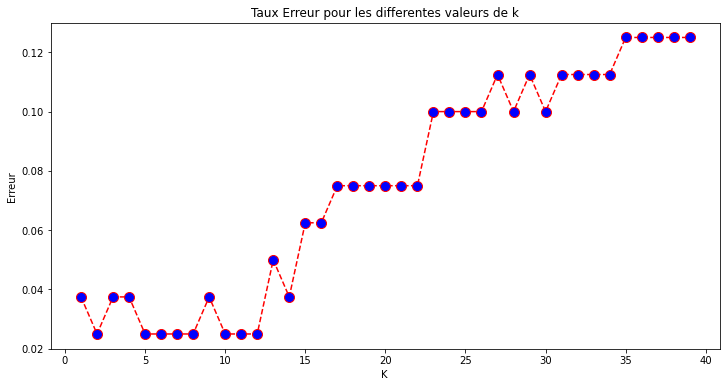

In [132]:
from sklearn.neighbors import KNeighborsClassifier

error = []
# Calculer l'erreur pour k entre 1 et 40 
#Pour chaque itération, l'err²eur moyenne pour les valeurs prédites 
#de l'ensemble de test est calculée et sauvegardée ds la liste Erreur.
# Tester k de 1 à 40 et la distance Manhattan
for i in range(1, 40):
    knn = KNeighborsClassifier(i,metric='manhattan')
    knn_model = knn.fit(X_train, y_train)
    pred_i = knn_model.predict(X_test)
    error.append(np.mean(pred_i != y_test))
plt.figure(figsize=(12, 6))
plt.plot(range(1, 40), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Taux Erreur pour les differentes valeurs de k')
plt.xlabel('K ')
plt.ylabel('Erreur')

In [133]:
from sklearn.model_selection import GridSearchCV

n_neighbors = list(range(1,100))
p=[1,2] #p = 1 manhattan_distance/p=2 euclidean_distance
#Convert to dictionary
hyperparameters = dict(n_neighbors=n_neighbors, p=p)
#Create new KNN object
knn_2 = KNeighborsClassifier()
#Use GridSearch
clf = GridSearchCV(knn_2, hyperparameters, cv=10)

#cv: number of folds of the cross validation

#Fit the model
best_model = clf.fit(X_train, y_train)
#Print The value of best Hyperparameters
print('Best p:', best_model.best_estimator_.get_params()['p'])
print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])

Best p: 2
Best n_neighbors: 2


In [134]:
# Afficher les paramètres qui donnent les meilleurs performances
best_parameters = clf.best_params_
print(best_parameters)

{'n_neighbors': 2, 'p': 2}


In [135]:
#Taux de bonne classification
best_result = clf.best_score_
print(best_result)

0.9875


In [136]:
names=[]
results=[]

In [137]:
knn = KNeighborsClassifier(2,p=2)
knn_model = knn.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)
names.append('KNN')
results.append(accuracy_score(y_test,y_pred_knn))
x=accuracy_score(y_test,y_pred_knn)
print(x)

0.975


In [138]:
df.tail()



,age,bp,sg,al,su,bgr,bu,sc,sod,pot,...,pc,pcc,ba,htn,dm,cad,appet,pe,ane,class
395,55.0,80.0,1.020,0.0,0.0,140.0,49.0,0.5,150.0,4.9,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
396,42.0,70.0,1.025,0.0,0.0,75.0,31.0,1.2,141.0,3.5,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
397,12.0,80.0,1.020,0.0,0.0,100.0,26.0,0.6,137.0,4.4,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
398,17.0,60.0,1.025,0.0,0.0,114.0,50.0,1.0,135.0,4.9,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
399,58.0,80.0,1.025,0.0,0.0,131.0,18.0,1.1,141.0,3.5,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [139]:
# arr = np.array([[17.0,60.0,1.025,0.0,0.0,114.0,50.0,1.0,135.0,4.9,14.2,51.0,7200.0,5.9,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]]) 
# y=knn_model.predict(arr)

# print(y)

In [140]:
print(classification_report(y_test,y_pred_knn))

              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98        52
         1.0       0.96      0.96      0.96        28

    accuracy                           0.97        80
   macro avg       0.97      0.97      0.97        80
weighted avg       0.97      0.97      0.97        80



##  Naive Bayes

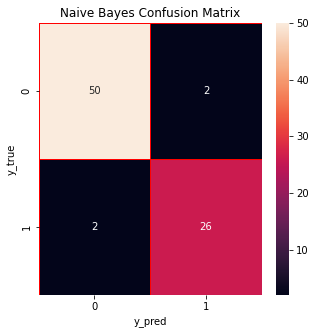

Naive Bayes accuracy = 95.0


In [141]:
score=[]
algorithms=[]
precision_score=[]
sensitivity_score=[]
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(X_train,y_train)

#Confusion Matrix 
from sklearn.metrics import confusion_matrix
y_pred=nb.predict(X_test)
y_pred_nb=y_pred
y_true=y_test
cm=confusion_matrix(y_true,y_pred)

#Confusion Matrix on Heatmap
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidths=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.title("Naive Bayes Confusion Matrix")
plt.show()

print("Naive Bayes accuracy =",nb.score(X_test,y_test)*100)
score.append(nb.score(X_test,y_test)*100)
algorithms.append("Naive Bayes")
accuracy_score(y_test,y_pred)
names.append('NB')
results.append(accuracy_score(y_test,y_pred))


# SVM

In [142]:
from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='rbf',C=0.1,random_state=0) # Linear Kernel

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)
y_pred_svm=y_pred

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_test, y_pred))
from sklearn.model_selection import train_test_split

names.append('SVM')
results.append(accuracy_score(y_test,y_pred))


Accuracy: 0.9625
Precision: 0.9310344827586207
Recall: 0.9642857142857143


# model compar before CFS

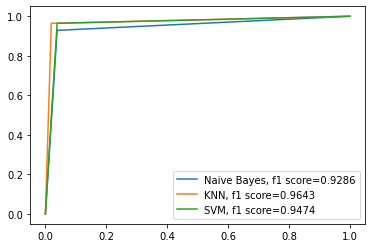

In [143]:
plt.figure(0).clf()
#fit Naive Bayes model and plot ROC curve
nb.fit(X_train, y_train)
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_nb)
auc = round(metrics.f1_score(y_test, y_pred_nb), 4)
plt.plot(fpr,tpr,label="Naive Bayes, f1 score="+str(auc))

#fit KNN model and plot ROC curve
knn.fit(X_train, y_train)
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_knn)
auc = round(metrics.f1_score(y_test, y_pred_knn), 4)
plt.plot(fpr,tpr,label="KNN, f1 score="+str(auc))

#fit SVM model and plot ROC curve
clf.fit(X_train, y_train)
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_svm)
auc = round(metrics.f1_score(y_test, y_pred_svm), 4)
plt.plot(fpr,tpr,label="SVM, f1 score="+str(auc))

#add legend
plt.legend()

## CFS

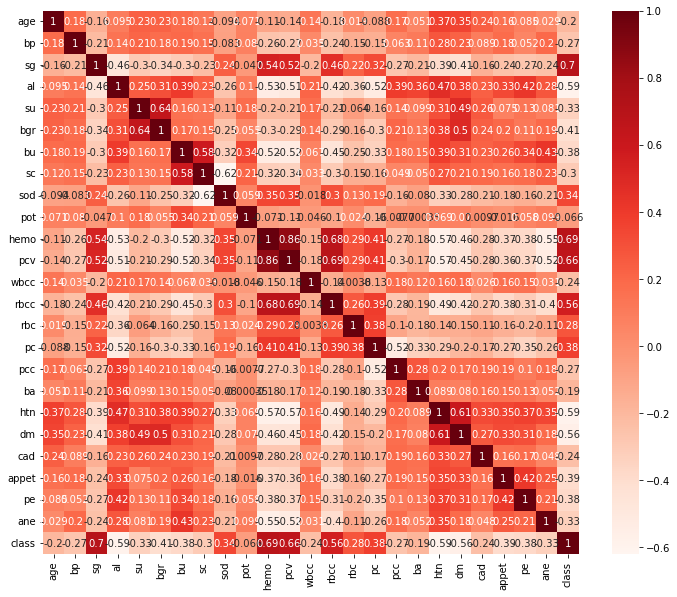

In [144]:
plt.figure(figsize=(12,10))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [145]:
df.columns


Index(['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo',
       'pcv', 'wbcc', 'rbcc', 'rbc', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad',
       'appet', 'pe', 'ane', 'class'],
      dtype='object')

In [146]:
# from scipy.stats import pointbiserialr
# from math import sqrt

# def getMerit(subset, label):
#     k = len(subset)

#     # average feature-class correlation
#     rcf_all = []
#     for feature in subset:
#         coeff = pointbiserialr( df[label], df[feature] )
#         rcf_all.append( abs( coeff.correlation ) )
#     rcf = np.mean( rcf_all )

#     # average feature-feature correlation
#     corr = df[subset].corr()
#     corr.values[np.tril_indices_from(corr.values)] = np.nan
#     corr = abs(corr)
#     rff = corr.unstack().mean()

#     return (k * rcf) / sqrt(k + k * (k-1) * rff)

In [147]:
# label = 'class'
# df.columns
# features = df.columns.tolist()
# features.remove(label)

In [148]:
# subset = [features[1], features[2], features[3], features[4]]
# corr = df[subset].corr()
# corr.values[np.tril_indices_from(corr.values)] = np.nan
# corr

In [149]:
# best_value = -1
# best_feature = ''
# for feature in features:
#     coeff = pointbiserialr( df[label], df[feature] )
#     abs_coeff = abs( coeff.correlation )
#     if abs_coeff > best_value:
#         best_value = abs_coeff
#         best_feature = feature

# print("Feature %s with merit %.4f"%(best_feature, best_value))

In [150]:
# class PriorityQueue:
#     def  __init__(self):
#         self.queue = []

#     def isEmpty(self):
#         return len(self.queue) == 0
    
#     def push(self, item, priority):
#         """
#         item already in priority queue with smaller priority:
#         -> update its priority
#         item already in priority queue with higher priority:
#         -> do nothing
#         if item not in priority queue:
#         -> push it
#         """
#         for index, (i, p) in enumerate(self.queue):
#             if (set(i) == set(item)):
#                 if (p >= priority):
#                     break
#                 del self.queue[index]
#                 self.queue.append( (item, priority) )
#                 break
#         else:
#             self.queue.append( (item, priority) )
        
#     def pop(self):
#         # return item with highest priority and remove it from queue
#         max_idx = 0
#         for index, (i, p) in enumerate(self.queue):
#             if (self.queue[max_idx][1] < p):
#                 max_idx = index
#         (item, priority) = self.queue[max_idx]
#         del self.queue[max_idx]
#         return (item, priority)

In [151]:
# queue = PriorityQueue()
# # push first tuple (subset, merit)
# queue.push([best_feature], best_value)
# # list for visited nodes
# visited = []
# temp_subset=[]

# # counter for backtracks
# n_backtrack = 0

# # limit of backtracks
# max_backtrack = 1000


In [152]:
# # repeat until queue is empty
# # or the maximum number of backtracks is reached
# while len(temp_subset)!=17:
#     # get element of queue with highest merit
#     subset, priority = queue.pop()

#     # check whether the priority of this subset
#     # is higher than the current best subset
#     if (priority< best_value):
#         n_backtrack += 1
#     else:
#         best_value = priority
#         best_subset = subset

#     # goal condition
#     #if (n_backtrack == max_backtrack):
#         #break
    
#     # iterate through all features and look of one can
#     # increase the merit
#     for feature in features:
#         temp_subset = subset + [feature]
        
#         # check if this subset has already been evaluated
#         for node in visited:
#             if (set(node) == set(temp_subset)):
#                 break
#         # if not, ...
#         else:
#             # ... mark it as visited
#             visited.append( temp_subset )
#             # ... compute merit
#             merit = getMerit(temp_subset, label)
#             # and push it to the queue
#             queue.push(temp_subset, merit)

In [153]:
# n_backtrack

In [154]:
# temp_subset

In [155]:
temp_subset=['sg',
 'hemo',
 'htn',
 'al',
 'dm',
 'pcv',
 'sod',
 'wbcc',
 'bgr',
 'sc',
 'appet',
 'rbcc',
 'bp',
 'rbc',
 'pe',
 'su',
 'ane']

In [156]:
# best_subset

In [157]:
moo=df[temp_subset]


In [158]:
moo.describe()

,sg,hemo,htn,al,dm,pcv,sod,wbcc,bgr,sc,appet,rbcc,bp,rbc,pe,su,ane
count,400.000000,400.000000,400.000000,400.000000,400.00000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,1.017207,12.612128,0.367500,1.026630,0.34250,39.072287,137.404206,8520.574245,149.387131,3.077800,0.205000,4.698977,76.297699,0.882500,0.190000,0.471934,0.150000
std,0.005500,2.779633,0.482728,1.294992,0.47514,8.376849,9.336981,2675.258776,78.285145,5.637946,0.404207,0.923645,13.664005,0.322418,0.392792,1.063093,0.357519
min,1.005000,3.100000,0.000000,0.000000,0.00000,9.000000,4.500000,2200.000000,22.000000,0.400000,0.000000,2.100000,50.000000,0.000000,0.000000,0.000000,0.000000
25%,1.013537,10.800000,0.000000,0.000000,0.00000,33.000000,135.000000,6744.612231,100.000000,0.900000,0.000000,4.100000,70.000000,1.000000,0.000000,0.000000,0.000000
50%,1.017553,13.000000,0.000000,0.000000,0.00000,41.000000,138.000000,8363.913439,122.000000,1.300000,0.000000,4.700000,80.000000,1.000000,0.000000,0.000000,0.000000
75%,1.020000,14.900000,1.000000,2.000000,1.00000,45.000000,141.000000,9989.542532,169.000000,2.900000,0.000000,5.268277,80.000000,1.000000,0.000000,0.000000,0.000000
max,1.025000,17.800000,1.000000,5.000000,1.00000,54.000000,163.000000,26400.000000,490.000000,76.000000,1.000000,8.000000,180.000000,1.000000,1.000000,5.000000,1.000000


In [246]:
X =  moo
y = df['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)


scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)



# KNN + CFS 

Text(0, 0.5, 'Erreur')

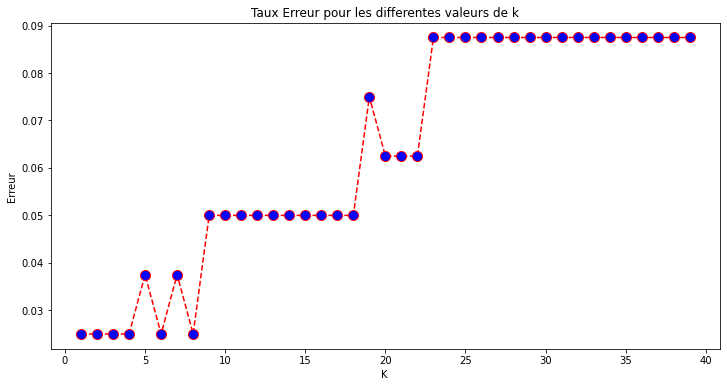

In [160]:
from sklearn.neighbors import KNeighborsClassifier

error = []
# Calculer l'erreur pour k entre 1 et 40 
#Pour chaque itération, l'err²eur moyenne pour les valeurs prédites 
#de l'ensemble de test est calculée et sauvegardée ds la liste Erreur.
# Tester k de 1 à 40 et la distance Manhattan
for i in range(1, 40):
    knn = KNeighborsClassifier(i,metric='manhattan')
    knn_model = knn.fit(X_train, y_train)
    pred_i = knn_model.predict(X_test)
    error.append(np.mean(pred_i != y_test))
plt.figure(figsize=(12, 6))
plt.plot(range(1, 40), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Taux Erreur pour les differentes valeurs de k')
plt.xlabel('K ')
plt.ylabel('Erreur')

In [161]:
from sklearn.model_selection import GridSearchCV

n_neighbors = list(range(1,100))
p=[1,2] #p = 1 manhattan_distance/p=2 euclidean_distance
#Convert to dictionary
hyperparameters = dict(n_neighbors=n_neighbors, p=p)
#Create new KNN object
knn_2 = KNeighborsClassifier()
#Use GridSearch
clf = GridSearchCV(knn_2, hyperparameters, cv=10)

#cv: number of folds of the cross validation

#Fit the model
best_model = clf.fit(X_train, y_train)
#Print The value of best Hyperparameters
print('Best p:', best_model.best_estimator_.get_params()['p'])
print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])

Best p: 2
Best n_neighbors: 2


In [162]:
# Afficher les paramètres qui donnent les meilleurs performances
best_parameters = clf.best_params_
print(best_parameters)

{'n_neighbors': 2, 'p': 2}


In [163]:
#Taux de bonne classification
best_result = clf.best_score_
print(best_result)

0.98125


In [164]:
knn = KNeighborsClassifier(2,p=2)
knn_model = knn.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)
y_pred_knn_cfs=y_pred_knn

In [165]:
accuracy_score( y_test,y_pred_knn)

0.9875

In [166]:
moo.head()

,sg,hemo,htn,al,dm,pcv,sod,wbcc,bgr,sc,appet,rbcc,bp,rbc,pe,su,ane
0,1.020,15.4,1.0,1.0,1.0,44.0,138.729722,7800.0,121.000000,1.2,0.0,5.200000,80.0,1.0,0.0,0.0,0.0
1,1.020,11.3,0.0,4.0,0.0,38.0,138.000000,6000.0,100.329368,0.8,0.0,5.682650,50.0,1.0,0.0,0.0,0.0
2,1.010,9.6,0.0,2.0,1.0,31.0,132.000000,7500.0,423.000000,1.8,1.0,3.209219,80.0,1.0,0.0,3.0,1.0
3,1.005,11.2,1.0,4.0,0.0,32.0,111.000000,6700.0,117.000000,3.8,1.0,3.900000,70.0,1.0,1.0,0.0,1.0
4,1.010,11.6,0.0,2.0,0.0,35.0,137.157838,7300.0,106.000000,1.4,0.0,4.600000,80.0,1.0,0.0,0.0,0.0


In [167]:
arr = np.array([[1.02,15.7,0,0,0,47,150,6700,140,0.5,0,4.9,80,1,0,0,0]]) 
arr = scaler.transform(arr)

yy=knn.predict(arr)
yy

array([1.])

# NAIVE BAYES WITH CFS

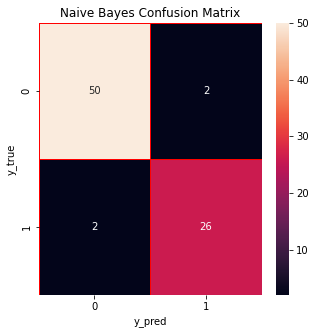

              precision    recall  f1-score   support

         0.0       0.96      0.96      0.96        52
         1.0       0.93      0.93      0.93        28

    accuracy                           0.95        80
   macro avg       0.95      0.95      0.95        80
weighted avg       0.95      0.95      0.95        80



In [168]:
nb = GaussianNB()
nb.fit(X_train,y_train)

#Confusion Matrix 
from sklearn.metrics import confusion_matrix
y_pred=nb.predict(X_test)
y_pref_nb_cfs=y_pred
y_true=y_test
cm=confusion_matrix(y_true,y_pred)

#Confusion Matrix on Heatmap
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidths=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.title("Naive Bayes Confusion Matrix")
plt.show()



print(classification_report(y_true,y_pred))

# SVM + CFS

In [169]:
from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='rbf',C=0.1) 

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)
y_pred_svm_cfs=y_pred
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.975
Precision: 0.9642857142857143
Recall: 0.9642857142857143


#  ADABOOST as feature selection

In [170]:
from sklearn.ensemble import AdaBoostClassifier

In [249]:
abc =AdaBoostClassifier(n_estimators=50)
model = abc.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [250]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.975


In [251]:
feats = pd.DataFrame(index=X.columns,data=model.feature_importances_,columns=['Importance'])
feats

,Importance
sg,0.18
hemo,0.14
htn,0.00
al,0.06
dm,0.02
pcv,0.10
sod,0.12
wbcc,0.06
bgr,0.04
sc,0.10


# Plot of models after cfs

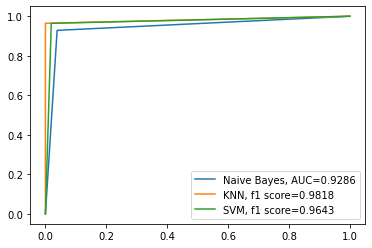

In [174]:
plt.figure(0).clf()
#fit Naive Bayes model and plot ROC curve
nb.fit(X_train, y_train)
fpr, tpr, _ = metrics.roc_curve(y_test, y_pref_nb_cfs)
auc = round(metrics.f1_score(y_test, y_pref_nb_cfs), 4)
plt.plot(fpr,tpr,label="Naive Bayes, AUC="+str(auc))

#fit KNN model and plot ROC curve
knn.fit(X_train, y_train)
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_knn_cfs)
auc = round(metrics.f1_score(y_test, y_pred_knn_cfs), 4)
plt.plot(fpr,tpr,label="KNN, f1 score="+str(auc))

#fit SVM model and plot ROC curve
clf.fit(X_train, y_train)
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_svm_cfs)
auc = round(metrics.f1_score(y_test, y_pred_svm_cfs), 4)
plt.plot(fpr,tpr,label="SVM, f1 score="+str(auc))

#add legend
plt.legend()

# SVM + CFS + ADABOOST

In [254]:
abc =AdaBoostClassifier(n_estimators=50,base_estimator=clf)
model = abc.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(metrics.classification_report(y_test, y_pred))


              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98        52
         1.0       1.00      0.93      0.96        28

    accuracy                           0.97        80
   macro avg       0.98      0.96      0.97        80
weighted avg       0.98      0.97      0.97        80



# bayes + CFS + BG

In [257]:
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.datasets import make_classification
from sklearn.svm import LinearSVC
bagc = BaggingClassifier(base_estimator=nb, n_estimators=31, random_state=314)
model = bagc.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(metrics.classification_report(y_test, y_pred))


              precision    recall  f1-score   support

         0.0       0.96      0.96      0.96        52
         1.0       0.93      0.93      0.93        28

    accuracy                           0.95        80
   macro avg       0.95      0.95      0.95        80
weighted avg       0.95      0.95      0.95        80



# KNN + CFS + BG

In [258]:
bagc = BaggingClassifier(base_estimator=knn, n_estimators=31, random_state=314)
model = bagc.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98        52
         1.0       0.96      0.96      0.96        28

    accuracy                           0.97        80
   macro avg       0.97      0.97      0.97        80
weighted avg       0.97      0.97      0.97        80



In [241]:
import numpy as np
from scipy.optimize import minimize , fmin_cg , fmin
from sklearn.metrics import hinge_loss , log_loss , confusion_matrix , accuracy_score , roc_auc_score
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import load_breast_cancer
import logging

# WEIGHTED KNN

In [259]:
X = moo.to_numpy()
y = df['class'].to_numpy()
weights = np.zeros(X.shape[1])
k =2

def knnWeights(weights , X,y , k):

    def dist(a,b):
        return np.sum(np.multiply(weights, np.abs(a-b)))

    distMat = pairwise_distances(X,metric=dist)
    kneighbors = np.argsort(distMat , axis=1)[:,1:k+1]

            # don't do probability because its a bad estimation to begin with
            #probs = np.count_nonzero(y[kneighbors] == 1 , axis=1)/k
    pred = np.round(np.sum(y[kneighbors] , axis=1)/k)
            #loss = 1-roc_auc_score(y,probs) #+ np.linalg.norm(weights , ord=2)
    loss = 1-accuracy_score(y,pred)
            #loss = log_loss(y,probs)
    return loss

logging.info("Learning Feature Weights")

Xtrain,Xtest,ytrain,ytest = train_test_split(X,y)

        #lweights = fmin(knnWeights , weights ,args=(df,k) ,maxiter=10, disp=True)
lweights = minimize(knnWeights , weights ,args=(Xtrain,ytrain,k) ,options={"maxiter":10})
lweights = lweights.x
print(lweights)

[ 2.34207153e-05  2.19569206e-05  1.11248398e-05  0.00000000e+00
  0.00000000e+00  2.69338226e-05  1.31741524e-05  1.59369103e-06
  4.81403938e-06  9.66104507e-06 -3.80586624e-06  1.96148491e-05
  3.93576256e-06  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -6.73345565e-06]
